In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
!unzip $(find /content/drive/MyDrive/data/gg -name "*.zip" -type f) -d /content/drive/MyDrive/data

Archive:  /content/drive/MyDrive/data/gg/test.zip
   creating: /content/drive/MyDrive/data/test/
  inflating: /content/drive/MyDrive/data/test/1S0SxmfbOus.002.mp4  
  inflating: /content/drive/MyDrive/data/test/2f7rLXwzP3s.000.mp4  
  inflating: /content/drive/MyDrive/data/test/38fE5B4ghw0.000.mp4  
  inflating: /content/drive/MyDrive/data/test/4TpJ1FT2w6Y.003.mp4  
  inflating: /content/drive/MyDrive/data/test/6waL_gUxtAM.004.mp4  
  inflating: /content/drive/MyDrive/data/test/6xlHkQDHxbs.000.mp4  
  inflating: /content/drive/MyDrive/data/test/7wsksuXYoMY.000.mp4  
  inflating: /content/drive/MyDrive/data/test/8aLr0vNobr4.000.mp4  
  inflating: /content/drive/MyDrive/data/test/AFvUxDwJB84.001.mp4  
  inflating: /content/drive/MyDrive/data/test/aMPe0uSKqF4.001.mp4  
  inflating: /content/drive/MyDrive/data/test/aqd4_4ga1fQ.004.mp4  
  inflating: /content/drive/MyDrive/data/test/AWyKLALCUyM.000.mp4  
  inflating: /content/drive/MyDrive/data/test/Bt5zyk-Xf9Q.000.mp4  
  inflating: /conte

In [2]:
%config IPCompleter.greedy=True

In [3]:
pip install ffmpeg-python

In [4]:
import librosa
import librosa.display
import numpy as np
import cupy as cp
import pandas as pd
import ffmpeg as ff
import os
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
import random
import cv2
import pickle
import datetime

In [5]:
def extract_audio_from_video(file_path: str) -> np.ndarray:
    inputfile = ff.input(file_path)
    out = inputfile.output('-', format='f32le', acodec='pcm_f32le', ac=1, ar='44100')
    raw = out.run(capture_stdout=True)
    del inputfile, out
    sr = 44100  # Частота дискретизации
    return np.frombuffer(raw[0], np.float32), sr

In [6]:
import librosa
import numpy as np

def preprocess_audio_series(raw_data: np.ndarray, sr: int) -> np.ndarray:
    N, M = 24, 1319

    # Вычисляем MFCC, используя явные аргументы y и sr
    mfcc_data = librosa.feature.mfcc(y=raw_data, sr=sr, n_mfcc=N)

    # Нормализация (приведение к нулевому среднему и единичной дисперсии)
    mfcc_data_standardized = (mfcc_data - np.mean(mfcc_data)) / np.std(mfcc_data)

    # Заполнение для обеспечения одинаковой длины
    number_of_columns_to_fill = M - mfcc_data_standardized.shape[1]
    padding = np.zeros((N, number_of_columns_to_fill))

    padded_data = np.hstack((padding, mfcc_data_standardized))



    # Изменение формы данных для последующей обработки
    return padded_data.reshape(N, M, 1)

In [7]:
def get_number_of_frames(file_path: str) -> int:
    probe = ff.probe(filePath)
    video_streams = [stream for stream in probe["streams"] if stream["codec_type"] == "video"]
    #width = video_streams[0]['coded_width']
    #height = video_streams[0]['coded_height']
    del probe
    return video_streams[0]['nb_frames']

In [8]:
def extract_N_video_frames(file_path: str, number_of_samples: int = 6) -> List[np.ndarray]:
    nb_frames = int(get_number_of_frames(file_path= filePath))

    video_frames = []
    random_indexes = random.sample(range(0, nb_frames), number_of_samples)

    cap = cv2.VideoCapture(filePath)
    for ind in random_indexes:
        cap.set(1,ind)
        res, frame = cap.read()
        video_frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    cap.release()
    del cap, random_indexes
    return video_frames

In [9]:
def resize_image(image: np.ndarray, new_size: Tuple[int,int]) -> np.ndarray:
    return cv2.resize(image, new_size, interpolation = cv2.INTER_AREA)

In [10]:
def crop_image_window(image: np.ndarray, training: bool = True) -> np.ndarray:
    height, width, _ = image.shape
    if training:
        MAX_N = height - 128
        MAX_M = width - 128
        rand_N_index, rand_M_index = random.randint(0, MAX_N) , random.randint(0, MAX_M)
        return image[rand_N_index:(rand_N_index+128),rand_M_index:(rand_M_index+128),:]
    else:
        N_index = (height - 128) // 2
        M_index = (width - 128) // 2
        return image[N_index:(N_index+128),M_index:(M_index+128),:]

In [11]:
def reading_label_data(file_name: str, dictionary: Dict[str,str]) -> np.ndarray:
    features = ['extraversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'openness']
    extracted_data = [float(dictionary[label][file_name]) for label in features]
    return np.stack(extracted_data).reshape(5,1)

In [12]:
def preprocessing_input(file_path: str, file_name: str, dictionary: Dict[str,str], training: bool = True) -> Tuple[np.ndarray,np.ndarray,np.ndarray]:
    #Audio
    extracted_audio_raw, sr = extract_audio_from_video(file_path= filePath)
    preprocessed_audio = preprocess_audio_series(raw_data= extracted_audio_raw,sr=sr)

    #Video
    sampled = extract_N_video_frames(file_path= filePath, number_of_samples= 6)
    resized_images = [resize_image(image= im, new_size= (248,140)) for im in sampled]
    cropped_images = [crop_image_window(image= resi,training= training) / 255.0 for resi in resized_images]
    preprocessed_video = np.stack(cropped_images)

    #Ground Truth
    video_gt = reading_label_data(file_name= file_name, dictionary= dictionary)
    del extracted_audio_raw, sampled, resized_images, cropped_images
    return (preprocessed_audio, preprocessed_video, video_gt)

### Getting train set

In [14]:
training_set_data = []
path = '/content/drive/MyDrive/data/x'
gt = pickle.load( open( "/content/drive/MyDrive/data/annotation_training.pkl", "rb" ), encoding='latin1' )
print("s")
t1 = datetime.datetime.utcnow()
print("d")
processed_files=0
max_files=2000
for filename in os.listdir(path):
    if processed_files >= max_files:
        break
    filePath = path+'/'+filename
    training_set_data.append(preprocessing_input(file_path= filePath, file_name= filename, dictionary= gt, training= True))
    processed_files+=1
t2 = datetime.datetime.utcnow()
#Measuring execution time
print('Elapsed time: ' + str(t2-t1))

s
d
Elapsed time: 0:22:53.116339


In [15]:
savename = 'training_set.dat'
with open(savename, "wb") as f:
    pickle.dump(training_set_data, f)

### Getting validation set

In [22]:
validation_set_data = []
path = '/content/drive/MyDrive/data/valid'
gt = pickle.load( open( "/content/drive/MyDrive/data/annotation_training.pkl", "rb" ), encoding='latin1' )
t1 = datetime.datetime.utcnow()
processed_files=0
max_files=700
for filename in os.listdir(path):
    if processed_files >= max_files:
        break
    filePath = path+'/'+filename
    print(filePath)
    validation_set_data.append(preprocessing_input(file_path= filePath, file_name= filename, dictionary= gt, training= False))
    print("ready")
    processed_files+=1
t2 = datetime.datetime.utcnow()
#Measuring execution time
print('Elapsed time: ' + str(t2-t1))

/content/drive/MyDrive/data/valid/nKLhatlbqEw.000.mp4
ready
/content/drive/MyDrive/data/valid/1cqwKxx6GF8.001.mp4
ready
/content/drive/MyDrive/data/valid/0gv5Z0qt2jc.000.mp4
ready
/content/drive/MyDrive/data/valid/nkmYbzMmrYw.004.mp4
ready
/content/drive/MyDrive/data/valid/naAGy30bnwA.005.mp4
ready
/content/drive/MyDrive/data/valid/ng42eoHytOA.003.mp4
ready
/content/drive/MyDrive/data/valid/nfN9qJSVank.000.mp4
ready
/content/drive/MyDrive/data/valid/0gv5Z0qt2jc.005.mp4
ready
/content/drive/MyDrive/data/valid/sTUJhj154Sc.003.mp4
ready
/content/drive/MyDrive/data/valid/uRY3aJAaogw.003.mp4
ready
/content/drive/MyDrive/data/valid/tepWDnvIuRg.005.mp4
ready
/content/drive/MyDrive/data/valid/onbyz01BC_Y.003.mp4
ready
/content/drive/MyDrive/data/valid/tiVKJWLzmk4.001.mp4
ready
/content/drive/MyDrive/data/valid/qkmEt0ofGq8.004.mp4
ready
/content/drive/MyDrive/data/valid/rzKtAeWgZH0.003.mp4
ready
/content/drive/MyDrive/data/valid/pPtzEnf5afw.005.mp4
ready
/content/drive/MyDrive/data/valid/vhugKR

In [23]:
savename = 'validation_set.dat'
with open(savename, "wb") as f:
    pickle.dump(validation_set_data, f)

### Getting test set

In [16]:
test_set_data = []
path = '/content/drive/MyDrive/data/test'
gt = pickle.load( open( "/content/drive/MyDrive/data/annotation_training.pkl", "rb" ), encoding='latin1' )
t1 = datetime.datetime.utcnow()
processed_files=0
max_files=300
for filename in os.listdir(path):
    if processed_files >= max_files:
        break

    filePath = path+'/'+filename
    print(filePath)
    test_set_data.append(preprocessing_input(file_path= filePath, file_name= filename, dictionary= gt, training= False))
    print("ready")
    processed_files+=1
t2 = datetime.datetime.utcnow()
#Measuring execution time
print('Elapsed time: ' + str(t2-t1))

/content/drive/MyDrive/data/test/simc6hmrUOE.005.mp4
ready
/content/drive/MyDrive/data/test/p7_MVQ3uGJc.003.mp4
ready
/content/drive/MyDrive/data/test/nR0h3WFbPfA.000.mp4
ready
/content/drive/MyDrive/data/test/s3m8DgUi6GM.004.mp4
ready
/content/drive/MyDrive/data/test/sSR1a5XW7n4.001.mp4
ready
/content/drive/MyDrive/data/test/tYpxPqwle5k.005.mp4
ready
/content/drive/MyDrive/data/test/qVrXROy4Ais.004.mp4
ready
/content/drive/MyDrive/data/test/qjWi69HY2Fc.000.mp4
ready
/content/drive/MyDrive/data/test/wzCdM6Fe_4A.004.mp4
ready
/content/drive/MyDrive/data/test/zvX4fNj0uxk.001.mp4
ready
/content/drive/MyDrive/data/test/xsLvl2qGrxU.003.mp4
ready
/content/drive/MyDrive/data/test/zNmuwZkaeVg.001.mp4
ready
/content/drive/MyDrive/data/test/cNXnowQb7rs.002.mp4
ready
/content/drive/MyDrive/data/test/aqd4_4ga1fQ.004.mp4
ready
/content/drive/MyDrive/data/test/J30sMEMrKjA.000.mp4
ready
/content/drive/MyDrive/data/test/EDshSjcCsoY.001.mp4
ready
/content/drive/MyDrive/data/test/MCr6FmFAhak.004.mp4
rea

In [17]:
savename = 'test_set.dat'
with open(savename, "wb") as f:
    pickle.dump(test_set_data, f)

### Restarting kernel to free up memory, and then load data

In [7]:
with open('training_set.dat', "rb") as training_file:
    train_set_data = pickle.load(training_file)

In [8]:
with open('validation_set.dat', "rb") as validation_file:
    validation_set_data = pickle.load(validation_file)

In [9]:
with open('test_set.dat', "rb") as test_file:
    test_set_data = pickle.load(test_file)

<Axes: ylabel='Density'>

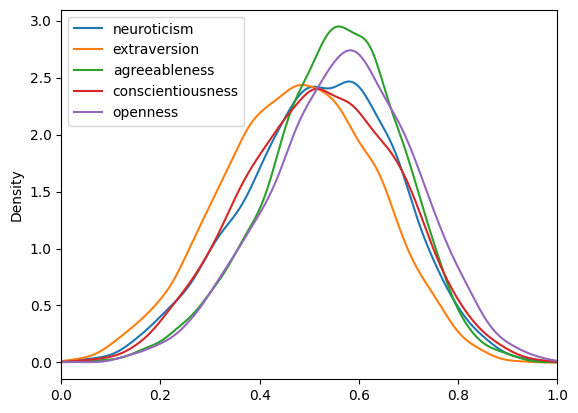

In [10]:
gt = pickle.load( open( "/content/drive/MyDrive/data/annotation_training.pkl", "rb" ), encoding='latin1' )
neuroticism = list(gt['neuroticism'].values())
extraversion = list(gt['extraversion'].values())
agreeableness = list(gt['agreeableness'].values())
conscientiousness = list(gt['conscientiousness'].values())
openness = list(gt['openness'].values())

df = pd.DataFrame({'neuroticism': neuroticism,'extraversion': extraversion,'agreeableness':agreeableness,'conscientiousness':conscientiousness,'openness':openness})
df.plot(kind='density',xlim=(0,1))

### Plotting number of samples in each set

In [11]:
print(len(train_set_data))
print(len(validation_set_data))
print(len(test_set_data))

1200
700
80


In [12]:
train_random_index = random.randint(0, len(train_set_data)-1)
validation_random_index = random.randint(0, len(validation_set_data)-1)
test_random_index = random.randint(0, len(test_set_data)-1)

In [13]:
shape = train_set_data[train_random_index][0].shape
mfcc_train = train_set_data[train_random_index][0].reshape(shape[0],shape[1])

shape = validation_set_data[validation_random_index][0].shape
mfcc_validation = validation_set_data[validation_random_index][0].reshape(shape[0],shape[1])

shape = test_set_data[test_random_index][0].shape
mfcc_train = test_set_data[test_random_index][0].reshape(shape[0],shape[1])

mfccs = [mfcc_train,mfcc_validation,mfcc_train]

### Displaying 3 video samples from train,validation and test sets

[array([[[0.69803922, 0.5372549 , 0.43921569],
        [0.69019608, 0.53333333, 0.42745098],
        [0.73333333, 0.56862745, 0.44705882],
        ...,
        [0.85490196, 0.82352941, 0.70196078],
        [0.8627451 , 0.82352941, 0.70588235],
        [0.8627451 , 0.82352941, 0.71764706]],

       [[0.78431373, 0.69803922, 0.56078431],
        [0.80784314, 0.7372549 , 0.58823529],
        [0.83137255, 0.74901961, 0.60784314],
        ...,
        [0.84705882, 0.81960784, 0.69803922],
        [0.85490196, 0.81960784, 0.70588235],
        [0.85490196, 0.81568627, 0.70588235]],

       [[0.75686275, 0.76862745, 0.67058824],
        [0.70980392, 0.72941176, 0.63137255],
        [0.79215686, 0.78431373, 0.65882353],
        ...,
        [0.85490196, 0.81960784, 0.69803922],
        [0.85098039, 0.81568627, 0.70588235],
        [0.85098039, 0.81568627, 0.70588235]],

       ...,

       [[0.32941176, 0.27843137, 0.25490196],
        [0.18431373, 0.14117647, 0.12941176],
        [0.16078431, 

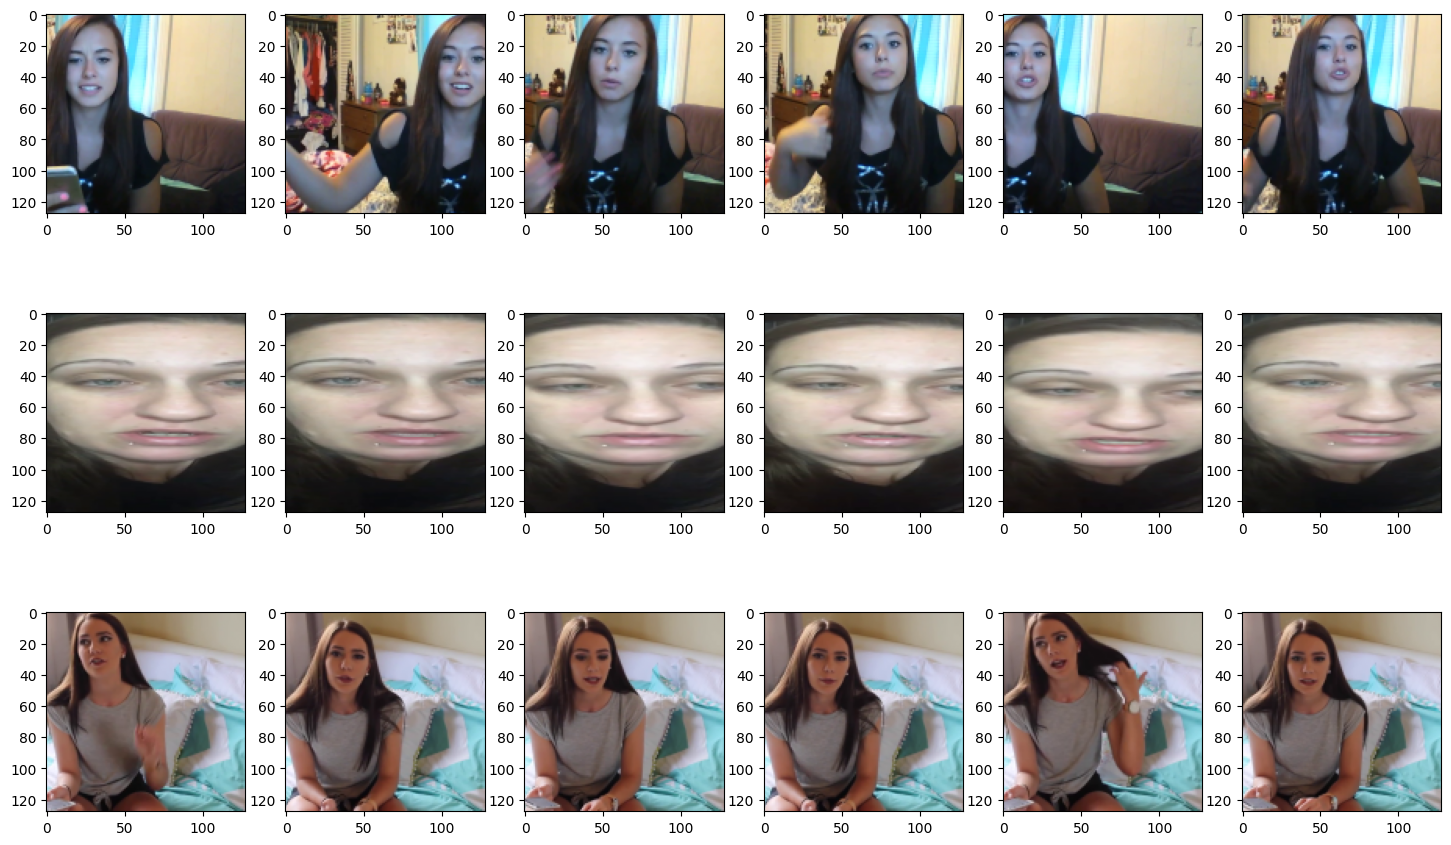

In [14]:
images_to_plot = []
images_to_plot.extend([(train_set_data[train_random_index][1])[i,:,:,:] for i in range(0,6)])
images_to_plot.extend([(validation_set_data[validation_random_index][1])[i,:,:,:] for i in range(0,6)])
images_to_plot.extend([(test_set_data[test_random_index][1])[i,:,:,:] for i in range(0,6)])

print(images_to_plot)
num_images_to_plot = min(len(images_to_plot), 18)
print(num_images_to_plot)
plt.figure(figsize=(18,11))

for i in range(num_images_to_plot):
    plt.subplot(3,6,i+1)
    plt.imshow(images_to_plot[i])
plt.show()

### Displaying audio MFCC

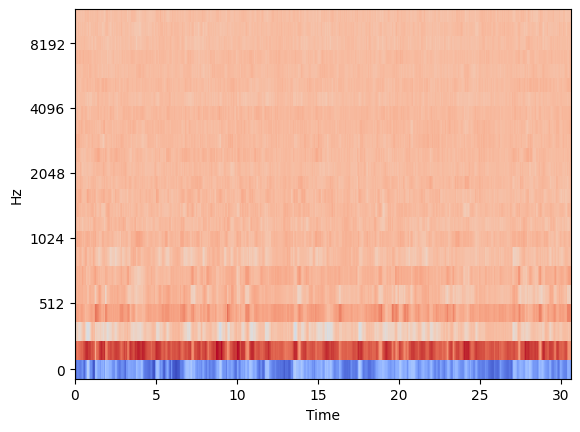

In [15]:
librosa.display.specshow(mfccs[0], x_axis='time', y_axis='mel')

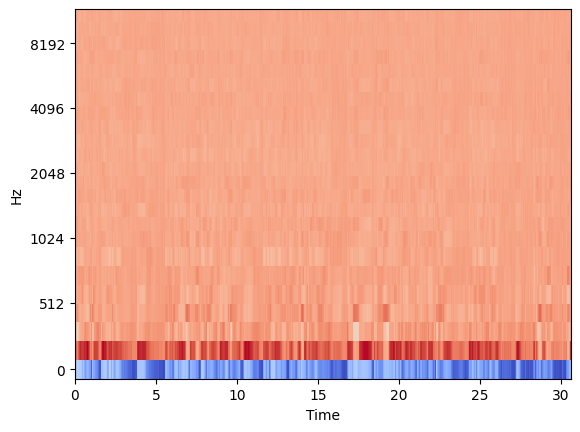

In [16]:
librosa.display.specshow(mfccs[1], x_axis='time', y_axis='mel')

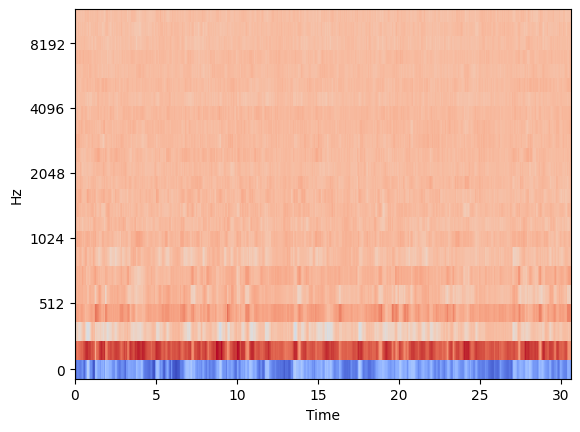

In [17]:
librosa.display.specshow(mfccs[2], x_axis='time', y_axis='mel')

### Printing personality traits

In [18]:
personality_train = train_set_data[train_random_index][2]
personality_validation = validation_set_data[validation_random_index][2]
personality_test = test_set_data[test_random_index][2]
personalities = ['Neuroticism','Extraversion','Agreeableness','Conscientiousness','Openness']

#### Train

In [19]:
for label, value in zip(personalities,personality_train):
    print(label + ': ' + str(value[0]))

Neuroticism: 0.4205607476635514
Extraversion: 0.4375
Agreeableness: 0.5384615384615384
Conscientiousness: 0.4563106796116505
Openness: 0.5888888888888889


#### Validation

In [20]:
for label, value in zip(personalities,personality_validation):
    print(label + ': ' + str(value[0]))

Neuroticism: 0.2336448598130841
Extraversion: 0.18749999999999997
Agreeableness: 0.21978021978021975
Conscientiousness: 0.2038834951456311
Openness: 0.22222222222222224


#### Test

In [21]:
for label, value in zip(personalities,personality_test):
    print(label + ': ' + str(value[0]))

Neuroticism: 0.588785046728972
Extraversion: 0.5625
Agreeableness: 0.4945054945054945
Conscientiousness: 0.6019417475728155
Openness: 0.7


### Converting sets to model format

In [22]:
def reshape_to_expected_input(dataset: List[Tuple[np.ndarray,np.ndarray,np.ndarray]]) -> Tuple[np.ndarray,np.ndarray,np.ndarray]:

    x0_list = []
    x1_list = []
    y_list = []
    for i in range(0,len(dataset)):
        x0_list.append(dataset[i][0])
        x1_list.append(dataset[i][1])
        y_list.append(dataset[i][2])
    return (np.stack(x0_list),np.stack(x1_list),np.stack(y_list))

In [23]:
train_input = reshape_to_expected_input(dataset= train_set_data)
del train_set_data
validation_input = reshape_to_expected_input(dataset= validation_set_data)
del validation_set_data
test_input = reshape_to_expected_input(dataset= test_set_data)
del test_set_data

## Creating Model

In [24]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Input, LSTM, Bidirectional, Lambda, Dropout, Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import TimeDistributed

### Audio subnetwork

In [25]:
audio_input = Input(shape=(24,1319,1))
audio_model = Conv2D(32, kernel_size=(3,3),activation='relu')(audio_input)
audio_model = BatchNormalization()(audio_model)
audio_model = MaxPooling2D(pool_size=(2, 2))(audio_model)
audio_model = Conv2D(32, kernel_size=(3,3),activation='relu')(audio_model)
audio_model = BatchNormalization()(audio_model)
audio_model = MaxPooling2D(pool_size=(2, 2))(audio_model)
audio_model = Flatten()(audio_model)
audio_model = Dense(128, activation='relu')(audio_model)
audio_subnetwork = Model(inputs=audio_input,outputs=audio_model)

### Visual subnetwork

In [26]:
from keras.applications import vgg16

In [27]:
visual_model = Input(shape=(6,128,128,3))

cnn = vgg16.VGG16(weights="imagenet", include_top=False, pooling='max')
cnn.trainable = False

In [28]:
encoded_frame = TimeDistributed(Lambda(lambda x: cnn(x)))(visual_model)
encoded_vid = LSTM(64)(encoded_frame)

visual_subnetwork = Model(inputs=visual_model,outputs=encoded_vid)

The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'block1_conv1/kernel:0' shape=(3, 3, 3, 64) dtype=float32>
  <tf.Variable 'block1_conv1/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'block1_conv2/kernel:0' shape=(3, 3, 64, 64) dtype=float32>
  <tf.Variable 'block1_conv2/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'block2_conv1/kernel:0' shape=(3, 3, 64, 128) dtype=float32>
  <tf.Variable 'block2_conv1/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'block2_conv2/kernel:0' shape=(3, 3, 128, 128) dtype=float32>
  <tf.Variable 'block2_conv2/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'block3_conv1/kernel:0' shape=(3, 3, 128, 256) dtype=float32>
  <tf.Variable 'block3_conv1/bias:0' shape=(256,) dtype=float32>
  <tf.Variable 'block3_conv2/kernel:0' shape=(3, 3, 256, 256) dtype=float32>
  <tf.Variable 'block3_conv2/bias:0' shape=(256,) dtype=float32>
  <tf.Variable 'block3_conv3/kernel:0' shape=(

In [29]:
combined = Concatenate()([audio_subnetwork.output, visual_subnetwork.output])
final1 = Dense(256, activation='relu')(combined)
final2 = Dense(5, activation='linear')(final1)

In [30]:
combined_network = Model(inputs=[audio_input, visual_model], outputs=final2)
combined_network.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 24, 1319, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 22, 1317, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 22, 1317, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                           

In [31]:
combined_network.compile(optimizer = 'adam',loss = 'mean_absolute_error',metrics=['mae'])

### Training

In [49]:
!pip install Tensorflow==2.10


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 105.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 107.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 49.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  

In [58]:
!pip install tensorflow==2.10.0

  Using cached tensorflow-2.10.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.1 kB)
  Using cached keras-2.10.0-py2.py3-none-any.whl.metadata (1.3 kB)
Using cached tensorflow-2.10.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (578.0 MB)
Using cached keras-2.10.0-py2.py3-none-any.whl (1.7 MB)


In [66]:
!cp training_set.dat /content/drive/MyDrive/data

^C


In [32]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=10)

In [33]:
# Принты для проверки данных
print("train_input[0] shape (audio data):", train_input[0].shape)  # Проверяем форму данных аудио
print("train_input[1] shape (image data):", train_input[1].shape)  # Проверяем форму данных изображений
print("train_input[2] shape (labels):", train_input[2].shape)  # Проверяем форму меток

print("validation_input[0] shape (audio data):", validation_input[0].shape)  # Проверяем форму данных аудио
print("validation_input[1] shape (image data):", validation_input[1].shape)  # Проверяем форму данных изображений
print("validation_input[2] shape (labels):", validation_input[2].shape)  # Проверяем форму меток

# Печать нескольких примеров данных (по необходимости)
print("Example audio data sample (train_input[0][0]):", train_input[0][0])  # Печать примера аудио данных
print("Example image data sample (train_input[1][0]):", train_input[1][0])  # Печать примера изображения
print("Example label (train_input[2][0]):", train_input[2][0])  # Печать метки

# Печать меток перед обучением
print("train labels example:", train_input[2][:5])  # Выводим первые 5 меток для тренировки
print("train_input[0] shape (audio data):", train_input[0].shape)  # Аудио данные
print("train_input[1] shape (image data):", train_input[1].shape)  # Изображения
print("train_input[2] shape (labels):", train_input[2].shape)  # Метки

print("validation_input[0] shape (audio data):", validation_input[0].shape)  # Аудио данные для валидации
print("validation_input[1] shape (image data):", validation_input[1].shape)  # Изображения для валидации
print("validation_input[2] shape (labels):", validation_input[2].shape)
# Запуск обучения
history = combined_network.fit(x = [train_input[0], train_input[1]],
                               y = train_input[2],
                               validation_data = ([validation_input[0], validation_input[1]], validation_input[2]),
                               epochs = 20,
                               verbose = 1,
                               callbacks = [early_stopping])

train_input[0] shape (audio data): (1200, 24, 1319, 1)
train_input[1] shape (image data): (1200, 6, 128, 128, 3)
train_input[2] shape (labels): (1200, 5, 1)
validation_input[0] shape (audio data): (700, 24, 1319, 1)
validation_input[1] shape (image data): (700, 6, 128, 128, 3)
validation_input[2] shape (labels): (700, 5, 1)
Example audio data sample (train_input[0][0]): [[[-4.61607218]
  [-4.48244762]
  [-4.63854074]
  ...
  [-5.21591997]
  [-5.22181463]
  [-5.67032719]]

 [[ 1.69944084]
  [ 1.64454472]
  [ 1.49524665]
  ...
  [ 0.88908786]
  [ 0.92204243]
  [ 0.89289981]]

 [[ 0.43127123]
  [ 0.49767795]
  [ 0.5193544 ]
  ...
  [ 0.10620487]
  [ 0.16646345]
  [ 0.23541185]]

 ...

 [[ 0.11468878]
  [ 0.08723167]
  [ 0.07121537]
  ...
  [ 0.02963689]
  [ 0.07888067]
  [ 0.13394342]]

 [[ 0.17717007]
  [ 0.16024405]
  [ 0.16588132]
  ...
  [ 0.07586426]
  [ 0.11352897]
  [ 0.1734397 ]]

 [[ 0.13441297]
  [ 0.08681143]
  [ 0.05026207]
  ...
  [ 0.03544258]
  [ 0.03604643]
  [ 0.08550204]

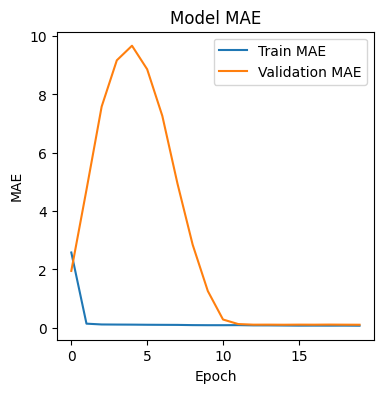

In [34]:
plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train MAE', 'Validation MAE'], loc='upper right')

#### Evaluate model on train set

In [35]:
loss, mae = combined_network.evaluate([test_input[0],test_input[1]],test_input[2], verbose=0)

print('Test loss: {}'.format(loss))

Test loss: 0.11054544150829315


### 1-MAE

In [36]:
print('1-MAE: ' + str(1-mae))

1-MAE: 0.8894545584917068


In [37]:
one_minus_mae_train = [1-maee for maee in history.history['mae']]
one_minus_mae_val = [1-maee for maee in history.history['val_mae']]

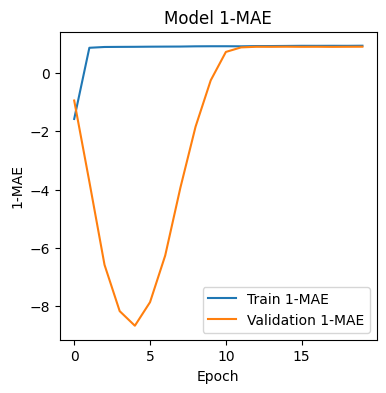

In [38]:
plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
plt.plot(one_minus_mae_train)
plt.plot(one_minus_mae_val)
plt.title('Model 1-MAE')
plt.ylabel('1-MAE')
plt.xlabel('Epoch')
plt.legend(['Train 1-MAE', 'Validation 1-MAE'], loc='lower right')

### Coefficient of determination (R^2)

In [39]:
y_pred = combined_network.predict([test_input[0],test_input[1]])
pred_shape = y_pred.shape
y_pred = y_pred.reshape(pred_shape[0],pred_shape[1],1)

3/3 [==============================] - 15s 4s/step


In [40]:
normalized = y_pred / np.max(y_pred)

Text(0.5, 0, 'Y_pred_Neuroticism')

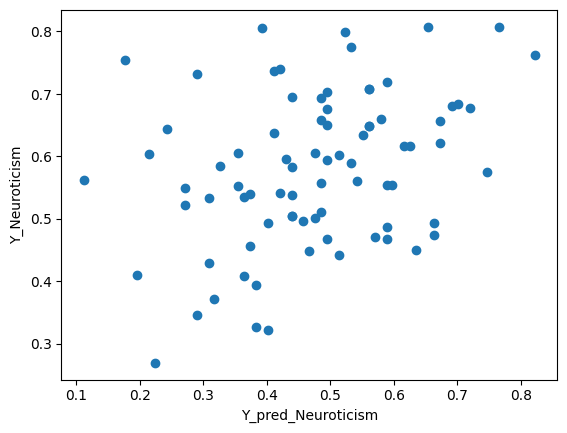

In [41]:
plt.scatter(test_input[2][:,0,:], normalized[:,0,:], marker='o');
plt.ylabel('Y_Neuroticism')
plt.xlabel('Y_pred_Neuroticism')

#### Coefficient Determination (R^2)

In [42]:
from sklearn.metrics import r2_score

In [43]:
pers = ['Neuroticism','Extraversion','Agreeableness','Conscientiousness','Openness']
r2s = [r2_score(test_input[2][:,i,:], normalized[:,i,:]) for i in range(5)]
for pers, r2 in zip(pers,r2s):
    print(pers + ': ' + str(r2))

Neuroticism: -0.6399919232127094
Extraversion: -0.9087465789633744
Agreeableness: -1.630783855455674
Conscientiousness: -0.36758460294045214
Openness: -1.0339859912061047


In [44]:
combined_network.save_weights('model_weights.h5')

In [47]:
combined_network.save('full_model.h5')

In [46]:
!pip freeze > requirements.txt